# Anti-cancer activity prediction

## Input: 
####It is a graph, with atoms representing nodes and bonds as edges.

## Output:
####It is a positive against non-small cell lung cancer, or negative otherwise. 
 

## Data mining function

#### Classification and prediction because we need to predict positive or negative.

## The challenges 

#### Upsampling data because the data imbalanced data and extract important features from data file and use some layers to prevent overfitting.

## Impact

#### Will this drug affect cancer or not?.

## Steps

#### 1- Reading data.
#### 2- Resampling data.
#### 3- Splitting the training set into train and test
#### 4- Visualizing/Inspecting a Sample
#### 5- Preprocessing(Tokenization, embedded and so on)      
#### 6- Trials


## Protocol 
#### I intend to use hold out method.


## Determine good/bad hyper-parameters
#### According to the accuracy graph if there is overfitting or underfitting and then I decided to change hyperparameters or add layers.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Colab_Notebooks/DM/Project_6')

##Import libraries

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from keras.regularizers import l2
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

import math
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

## Read SDF format data (structured-data format)

In [ ]:
def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')       #Split in $$$$ that means the first sample is ended and so on
    
    #Extract important information from the file
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0       #Output(labels)
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):    #Split in each tab
                feature = l.split()
                node = feature[3]       #Node character(S,O,N,C)
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):    #Linke between nodes
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                
        
        

In [ ]:
#Read training data
training_set = read_sdf('train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [ ]:
#Reading testing data
testing_set  = read_sdf('test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

**Imbalanced data**

It refers to datasets in which the target class has an unequal distribution of observations, i.e. one class label has a large sample size while the other has a small number. So we can solved it by Resampling (Oversampling and Undersampling)

In [ ]:
#Check data balanced or not 
np.unique(np.array(training_set)[:,2],return_counts=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


(array([0, 1], dtype=object), array([23806,  1218]))

In [ ]:
X_train = pd.DataFrame(np.array(training_set)[:,:-1])
y_train = pd.DataFrame(np.array(training_set)[:,2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
from sklearn.utils import resample

resampling = X_train.copy()
resampling[2] = y_train.values
class_0 = resampling[resampling[2]==0]
class_1 = resampling[resampling[2]==1]
class_1_resample = resample(class_1, replace=True, n_samples = 23806)
data_upsampling = pd.concat([class_0, class_1_resample])

training_set = data_upsampling.values.tolist()

In [ ]:
np.unique(np.array(training_set)[:,2],return_counts=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(array([0, 1], dtype=object), array([23806, 23806]))

In [ ]:
#Splitting the training set into train and test
training_set, validation_set = train_test_split(training_set, test_size=0.15, random_state= 0)

## Visualizing/Inspecting a Sample

In [ ]:
colors = cm.rainbow(np.linspace(0, 1, 50))

In [ ]:
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

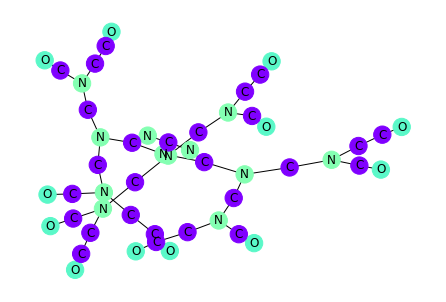

In [ ]:
plt.clf()
visualize(training_set[0])

In [ ]:
print('length of training_set:', len(training_set))
print('length of traiing_set[0]:', len(training_set[0]))
print('length of testing_set:', len(testing_set))
print('length of testing_set[0]:', len(testing_set[0]))

length of training_set: 40470
length of traiing_set[0]: 3
length of testing_set: 12326
length of testing_set[0]: 3


## Preprocessing

**Embedded**: is a machine learning algorithm that starts with random weights and learns an embedding for all of the words in the training dataset.

**Tokenizer** converts unique words into numbers and then apply this to all lines of data.

**Graph Neural Networks (GNNs)** are a subset of deep learning algorithms that do inference on data represented by graphs.

In [ ]:
max_vocab = 500       #Vocabular max number
max_len = 100

#Tokenizer converts unique characters into numbers
# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [ ]:
def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]                              #s[0] ---> nodes
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)           #Convert characters into numbers
    sample_nodes = pad_sequences(sample_nodes, padding='post')          #Padding: to all samples have the same length
    max_nodes_len = np.shape(sample_nodes)[1]                           #shape: (num of samples, number of nodes)
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]        #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0]                            #make sure all elements are non-zero
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)      #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)             #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):        #To generate multiple batches
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():          #k: labels, v: values
        print(k)
        print(v)
        #print(len(v))
        pass
    print('label', train_batch[1])
    break


data
[2 2 2 2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 2 2 2 2 2 2 2
 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
edges
[[  0  12]
 [  0  22]
 [  1  15]
 [  1  22]
 [  2  18]
 [  3  20]
 [  4  21]
 [  5  23]
 [  6  26]
 [  7  27]
 [  8  33]
 [  9  36]
 [  9  40]
 [ 10  36]
 [ 11  25]
 [ 11  38]
 [ 11  39]
 [ 12  14]
 [ 12  21]
 [ 12  32]
 [ 13  15]
 [ 13  16]
 [ 13  18]
 [ 14  15]
 [ 14  24]
 [ 16  20]
 [ 16  23]
 [ 17  19]
 [ 17  20]
 [ 17  26]
 [ 18  19]
 [ 19  30]
 [ 21  25]
 [ 22  27]
 [ 23  24]
 [ 25  27]
 [ 26  29]
 [ 28  29]
 [ 28  30]
 [ 28  31]
 [ 29  34]
 [ 31  33]
 [ 31  36]
 [ 33  35]
 [ 33  37]
 [ 34  35]
 [ 51  61]
 [ 51  65]
 [ 52  61]
 [ 52  67]
 [ 53  62]
 [ 54  63]
 [

In [ ]:
!pip install --quiet tf2_gnn

# https://github.com/ /tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput

     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 73 kB 1.9 MB/s 
     |████████████████████████████████| 134 kB 58.6 MB/s 
     |████████████████████████████████| 1.2 MB 63.2 MB/s 
     |████████████████████████████████| 346 kB 46.4 MB/s 
     |████████████████████████████████| 462 kB 64.1 MB/s 
     |████████████████████████████████| 79 kB 8.3 MB/s 
     |████████████████████████████████| 178 kB 65.7 MB/s 
     |████████████████████████████████| 3.6 MB 45.9 MB/s 
     |████████████████████████████████| 85 kB 3.5 MB/s 
     |████████████████████████████████| 41 kB 476 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.


#Trials

## GNN: Graph Neural Networks are a general neural network architecture
It has Nodes v ∈ V take unique values and edges are pairs e = (v, v0) ∈ V × V
Graphs may also contain node labels lv ∈ {1, . . . , LV } for each node v and edge labels or edge types le ∈ {1, . . . , LE } for each edge.


### GGNN(Gated Graph Sequence Neural Networks): 
That is suitable for non-sequential outputs and it is used backpropagation through time in order to compute gradients. and it is unroll recurrence for a fixed number of steps and just use backpropagation through time with modern optimization methods. 


### RGCN(Relational Graph Convolutional Networks):
Encode multi-relational data. It is performed an aggregation of the node representation achieved by the GCN for each type of relation.

### RGAT(Relational Graph Attention Networks):
It uses gated skip connections to improve long-range modeling between nodes and uses a more scalable vector-based approach for parameterizing relations.

## Before Imbalanced data

**Trial_1**

Layer: GNN

without message_calculation_class

Score: 0.68685

---

**Trial_2**

Layer: GNN

without message_calculation_class

Score: 0.72763

---

## After solved Imbalanced data problem

**Trial_3**

Layer: GNN

without message_calculation_class

Score: 0.83173

---

**Trial_4**

Layer: GNN

Using message_calculation_class = 'GGNN'

Score: 0.84318

---

**Trial_5**

Layer: GNN

Using message_calculation_class = 'GGNN'

Score: 0.87102

---

**Trial_6**

Layer: GNN

Using message_calculation_class = 'RGCN'

Score: 0.82031

---

**Trial_7**

Layer: GNN

Using message_calculation_class = 'RGCN'

Score: 0.81744

---

**Trial_8**

Layer: GNN

Using message_calculation_class = 'RGCN'

Score: 0.80778

---

**Trial_9**

Layer: GNN

Using message_calculation_class = 'RGAT'

Score: 0.80779

---

**Trial_10**

Layer: GNN

Using message_calculation_class = 'RGAT'

Score: 0.82707

---


##Imbalanced data

### Trial_1
Layer: GNN

without message_calculation_class

I think the accuracy will be good because I did upsampling to the training data.

In [ ]:
data = keras.Input(batch_shape=(None,))           #Input to layer

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Links
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(                               #segment_mean: computes the mean along segments of a tensor.
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [ ]:
# compile model with loss values for each task, AUC matrix 
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Fit the model
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(                #GNN model
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=50, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a larg

1330/1330 [==============================] - 31s 22ms/step - loss: 0.2211 - auc: 0.5109 - val_loss: 0.2034 - val_auc: 0.5778
Epoch 2/50
1330/1330 [==============================] - 33s 24ms/step - loss: 0.1941 - auc: 0.6279 - val_loss: 0.2000 - val_auc: 0.6207
Epoch 3/50
1330/1330 [==============================] - 19s 14ms/step - loss: 0.1912 - auc: 0.6534 - val_loss: 0.2106 - val_auc: 0.6130
Epoch 4/50
1330/1330 [==============================] - 17s 13ms/step - loss: 0.1870 - auc: 0.6788 - val_loss: 0.2099 - val_auc: 0.6092
Epoch 5/50
1330/1330 [==============================] - 18s 14ms/step - loss: 0.1871 - auc: 0.6840 - val_loss: 0.1982 - val_auc: 0.6281
Epoch 6/50
1330/1330 [==============================] - 24s 18ms/step - loss: 0.1876 - auc: 0.6730 - val_loss: 0.1964 - val_auc: 0.5635
Epoch 7/50
1330/1330 [==============================] - 23s 17ms/step - loss: 0.1885 - auc: 0.6624 - val_loss: 0.2138 - val_auc: 0.5808
Epoch 8/50
1330/1330 [==============================] - 23s

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)

y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.06407338, 0.02619812, 0.02102762, ..., 0.02063465, 0.02493054,
       0.03299677], dtype=float32)

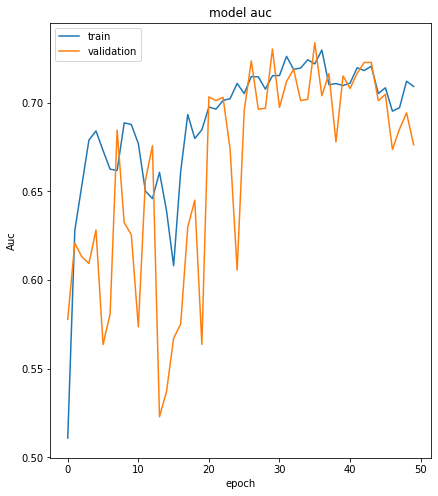

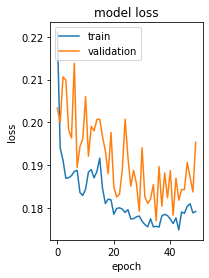

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Colab_Notebooks/DM/Project_6/sample_submission_1.csv')

Private score: 0.68685

### Trial_2
Layer: GNN

without message_calculation_class

The accuracy very bad so I think the accuracy will be improved or increased if I will add dropout hyperprameter to reduce overfitting.

In [ ]:
data = keras.Input(batch_shape=(None,))           #Input to layer

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Links
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["layer_input_dropout_rate"] = 0.2
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(                               #segment_mean: computes the mean along segments of a tensor.
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

In [ ]:
# compile model with loss values for each task, AUC matrix 
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Fit the model
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(                #GNN model
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=50, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_values:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense

1330/1330 [==============================] - 22s 14ms/step - loss: 0.2184 - auc: 0.5240 - val_loss: 0.2191 - val_auc: 0.5567
Epoch 2/50
1330/1330 [==============================] - 19s 14ms/step - loss: 0.1990 - auc: 0.6159 - val_loss: 0.2068 - val_auc: 0.6404
Epoch 3/50
1330/1330 [==============================] - 19s 14ms/step - loss: 0.1924 - auc: 0.6620 - val_loss: 0.2019 - val_auc: 0.6174
Epoch 4/50
1330/1330 [==============================] - 19s 14ms/step - loss: 0.1925 - auc: 0.6458 - val_loss: 0.1970 - val_auc: 0.6284
Epoch 5/50
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1899 - auc: 0.6612 - val_loss: 0.2013 - val_auc: 0.5979
Epoch 6/50
1330/1330 [==============================] - 19s 14ms/step - loss: 0.1887 - auc: 0.6680 - val_loss: 0.2089 - val_auc: 0.5672
Epoch 7/50
1330/1330 [==============================] - 19s 14ms/step - loss: 0.1891 - auc: 0.6595 - val_loss: 0.1911 - val_auc: 0.6639
Epoch 8/50
1330/1330 [==============================] - 19s

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)

y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.0973984 , 0.04975486, 0.02887627, ..., 0.01693413, 0.01569897,
       0.02898219], dtype=float32)

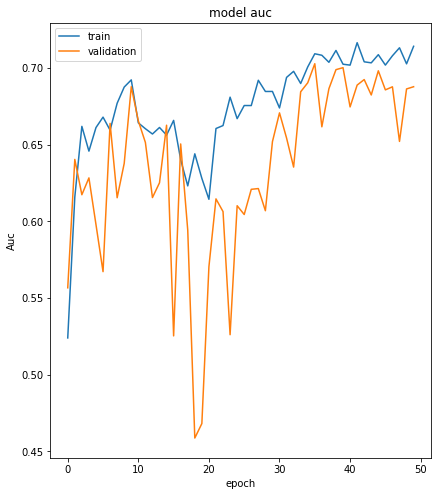

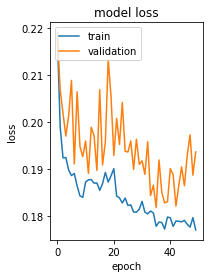

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Colab_Notebooks/DM/Project_6/sample_submission_2.csv')

Private score: 0.72763

##After solved Imbalanced data problem

### Trial_3
Layer: GNN

without message_calculation_class

I think the accuracy will be good because I did upsampling to the training data.

In [ ]:
data = keras.Input(batch_shape=(None,))           #Input to layer

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Links
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(                               #segment_mean: computes the mean along segments of a tensor.
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []        

In [ ]:
# compile model with loss values for each task, AUC matrix 
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Fit the model
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(                #GNN model
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=50, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

2530/2530 [==============================] - 85s 17ms/step - loss: 0.6225 - auc: 0.7102 - val_loss: 0.6028 - val_auc: 0.7434
Epoch 2/50
2530/2530 [==============================] - 36s 14ms/step - loss: 0.5954 - auc: 0.7461 - val_loss: 0.6179 - val_auc: 0.7482
Epoch 3/50
2530/2530 [==============================] - 37s 14ms/step - loss: 0.5826 - auc: 0.7626 - val_loss: 0.5731 - val_auc: 0.7819
Epoch 4/50
2530/2530 [==============================] - 36s 14ms/step - loss: 0.5725 - auc: 0.7728 - val_loss: 0.5719 - val_auc: 0.7891
Epoch 5/50
2530/2530 [==============================] - 36s 14ms/step - loss: 0.5612 - auc: 0.7838 - val_loss: 0.5618 - val_auc: 0.7904
Epoch 6/50
2530/2530 [==============================] - 36s 14ms/step - loss: 0.5529 - auc: 0.7924 - val_loss: 0.5610 - val_auc: 0.8008
Epoch 7/50
2530/2530 [==============================] - 35s 14ms/step - loss: 0.5403 - auc: 0.8041 - val_loss: 0.5413 - val_auc: 0.8179
Epoch 8/50
2530/2530 [==============================] - 36s

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)

y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.38038447, 0.32010582, 0.00940025, ..., 0.00736576, 0.15121874,
       0.9873854 ], dtype=float32)

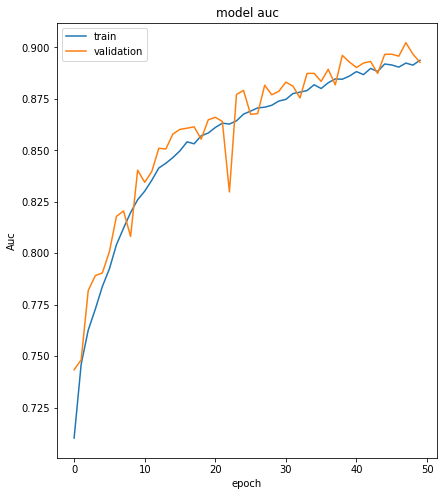

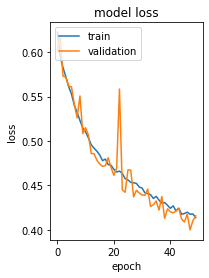

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Colab_Notebooks/DM/Project_6/sample_submission_3.csv')

Private score: 0.83173

### Trial_4
Layer: GNN

Using message_calculation_class = 'GGNN'

Accuracy in the previous trial may be good because Gating it makes the propagation model better. so I will try to use params['message_calculation_class'] to improve the accuracy, and I will change batch size. 

I will add early stopping to prevent overfitting. 

In [ ]:
data = keras.Input(batch_shape=(None,))           #Input to layer

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Links
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params['message_calculation_class'] = 'GGNN'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(                               #segment_mean: computes the mean along segments of a tensor.
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

In [ ]:
# compile model with loss values for each task, AUC matrix 
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Fit the model
batch_size = 20
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(                #GNN model
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=25, repeat=True
    ),
    validation_steps=num_batchs_validation, callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5)
    ],
)

Epoch 1/50
2024/2024 [==============================] - 51s 25ms/step - loss: 0.4935 - auc: 0.8417 - val_loss: 0.5073 - val_auc: 0.8476
Epoch 2/50
2024/2024 [==============================] - 51s 25ms/step - loss: 0.4712 - auc: 0.8576 - val_loss: 0.4559 - val_auc: 0.8712
Epoch 3/50
2024/2024 [==============================] - 60s 29ms/step - loss: 0.4486 - auc: 0.8722 - val_loss: 0.4378 - val_auc: 0.8792
Epoch 4/50
2024/2024 [==============================] - 57s 28ms/step - loss: 0.4297 - auc: 0.8836 - val_loss: 0.4424 - val_auc: 0.8792
Epoch 5/50
2024/2024 [==============================] - 54s 27ms/step - loss: 0.4146 - auc: 0.8922 - val_loss: 0.4055 - val_auc: 0.8978
Epoch 6/50
2024/2024 [==============================] - 53s 26ms/step - loss: 0.3973 - auc: 0.9014 - val_loss: 0.4212 - val_auc: 0.9036
Epoch 7/50
2024/2024 [==============================] - 53s 26ms/step - loss: 0.3807 - auc: 0.9097 - val_loss: 0.3938 - val_auc: 0.9057
Epoch 8/50
2024/2024 [==========================

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)

y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([9.7986329e-01, 3.8909912e-04, 3.3992529e-04, ..., 8.1820426e-06,
       2.3136085e-05, 9.9854445e-01], dtype=float32)

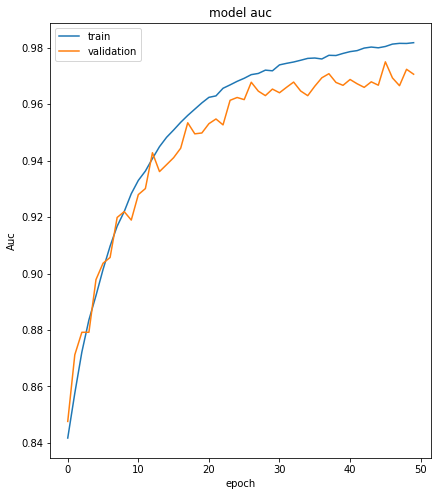

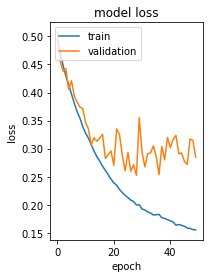

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Colab_Notebooks/DM/Project_6/sample_submission_4.csv')

Private score: 0.84318

### Trial_5
Layer: GNN

Using message_calculation_class = 'GGNN'

Accuracy in the previous trial improved so I will use layer_input_dropout_rate to improve the accuracy and prevent overfitting.

In [ ]:
data = keras.Input(batch_shape=(None,))           #Input to layer

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Links
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params['message_calculation_class'] = 'GGNN'
params['layer_input_dropout_rate'] = 0.2
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(                               #segment_mean: computes the mean along segments of a tensor.
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []        

In [ ]:
# compile model with loss values for each task, AUC matrix 
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Fit the model
batch_size = 20
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(                #GNN model
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=25, repeat=True
    ),
    validation_steps=num_batchs_validation, callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5)
    ],
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

2024/2024 [==============================] - 121s 29ms/step - loss: 0.6290 - auc: 0.6990 - val_loss: 0.5997 - val_auc: 0.7431
Epoch 2/50
2024/2024 [==============================] - 56s 28ms/step - loss: 0.5824 - auc: 0.7612 - val_loss: 0.5495 - val_auc: 0.7977
Epoch 3/50
2024/2024 [==============================] - 56s 27ms/step - loss: 0.5581 - auc: 0.7868 - val_loss: 0.5381 - val_auc: 0.8123
Epoch 4/50
2024/2024 [==============================] - 56s 28ms/step - loss: 0.5367 - auc: 0.8068 - val_loss: 0.5320 - val_auc: 0.8300
Epoch 5/50
2024/2024 [==============================] - 69s 34ms/step - loss: 0.5179 - auc: 0.8225 - val_loss: 0.5025 - val_auc: 0.8378
Epoch 6/50
2024/2024 [==============================] - 56s 28ms/step - loss: 0.5059 - auc: 0.8319 - val_loss: 0.4849 - val_auc: 0.8498
Epoch 7/50
2024/2024 [==============================] - 57s 28ms/step - loss: 0.4976 - auc: 0.8383 - val_loss: 0.4772 - val_auc: 0.8551
Epoch 8/50
2024/2024 [==============================] - 61

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)

y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([9.7604001e-01, 6.0112572e-01, 4.1674376e-03, ..., 7.1735943e-05,
       3.3155084e-04, 9.4830543e-01], dtype=float32)

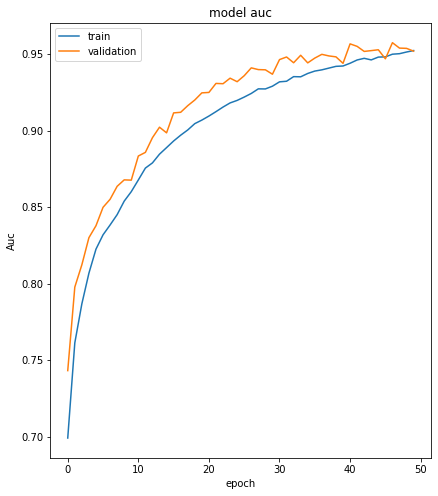

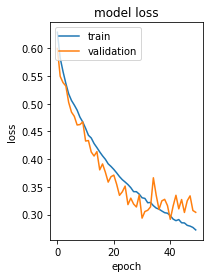

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Colab_Notebooks/DM/Project_6/sample_submission_5.csv')

Private score: 0.87102

### Trial_6
Layer: GNN

Using message_calculation_class = 'RGCN'

I will try to use different message_calculation_class with layer_input_dropout_rate to improve the accuracy and reduce the overfitting.

In [ ]:
data = keras.Input(batch_shape=(None,))           #Input to layer

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Links
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params['message_calculation_class'] = 'RGCN'
params['layer_input_dropout_rate'] = 0.2          #Dropout to prevent overfitting
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(                               #segment_mean: computes the mean along segments of a tensor.
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []        

In [ ]:
# compile model with loss values for each task, AUC matrix 
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Fit the model
batch_size = 20
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(                #GNN model
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=25,
    validation_data=gen_batch(
        validation_set, batch_size=25, repeat=True
    ),
    validation_steps=num_batchs_validation, callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5)
    ],
)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_values:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense

2024/2024 [==============================] - 39s 18ms/step - loss: 0.6280 - auc: 0.7004 - val_loss: 0.6167 - val_auc: 0.7239
Epoch 2/25
2024/2024 [==============================] - 36s 18ms/step - loss: 0.6031 - auc: 0.7352 - val_loss: 0.5877 - val_auc: 0.7618
Epoch 3/25
2024/2024 [==============================] - 37s 18ms/step - loss: 0.5949 - auc: 0.7483 - val_loss: 0.5932 - val_auc: 0.7583
Epoch 4/25
2024/2024 [==============================] - 43s 21ms/step - loss: 0.5883 - auc: 0.7571 - val_loss: 0.6022 - val_auc: 0.7558
Epoch 5/25
2024/2024 [==============================] - 49s 24ms/step - loss: 0.5804 - auc: 0.7672 - val_loss: 0.5718 - val_auc: 0.7803
Epoch 6/25
2024/2024 [==============================] - 45s 22ms/step - loss: 0.5727 - auc: 0.7753 - val_loss: 0.5739 - val_auc: 0.7885
Epoch 7/25
2024/2024 [==============================] - 39s 19ms/step - loss: 0.5641 - auc: 0.7817 - val_loss: 0.5685 - val_auc: 0.7772
Epoch 8/25
2024/2024 [==============================] - 37s

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)

y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.11119384, 0.93067145, 0.18560877, ..., 0.08478308, 0.13255388,
       0.21629715], dtype=float32)

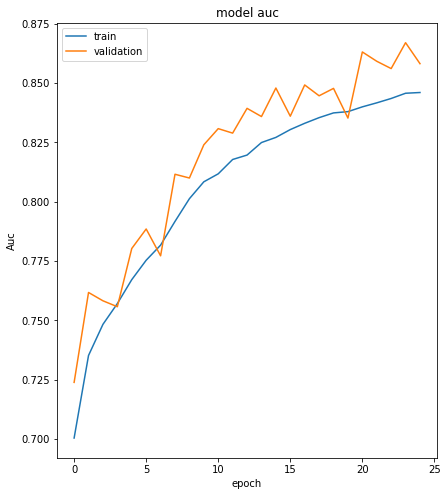

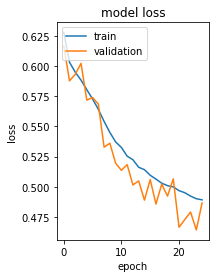

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Colab_Notebooks/DM/Project_6/sample_submission_6.csv')

Private score: 0.82031

### Trial_7
Layer: GNN

Using message_calculation_class = 'RGCN'

According to the previous trial i will increase the epochs to train and I will change number of hidden dimension.

In [ ]:
data = keras.Input(batch_shape=(None,))           #Input to layer

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Links
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params['message_calculation_class'] = 'RGCN'
params['layer_input_dropout_rate'] = 0.3          #Dropout to prevent overfitting
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(                               #segment_mean: computes the mean along segments of a tensor.
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []        

In [ ]:
# compile model with loss values for each task, AUC matrix 
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Fit the model
batch_size = 20
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(                #GNN model
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=25,
    validation_data=gen_batch(
        validation_set, batch_size=30, repeat=True
    ),
    validation_steps=num_batchs_validation, callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5)
    ],
)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_values:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense

2024/2024 [==============================] - 38s 18ms/step - loss: 0.6294 - auc: 0.6971 - val_loss: 0.6118 - val_auc: 0.7316
Epoch 2/25
2024/2024 [==============================] - 36s 18ms/step - loss: 0.6027 - auc: 0.7368 - val_loss: 0.6018 - val_auc: 0.7539
Epoch 3/25
2024/2024 [==============================] - 36s 18ms/step - loss: 0.5974 - auc: 0.7448 - val_loss: 0.5921 - val_auc: 0.7570
Epoch 4/25
2024/2024 [==============================] - 36s 18ms/step - loss: 0.5916 - auc: 0.7532 - val_loss: 0.5875 - val_auc: 0.7623
Epoch 5/25
2024/2024 [==============================] - 36s 18ms/step - loss: 0.5893 - auc: 0.7573 - val_loss: 0.5803 - val_auc: 0.7749
Epoch 6/25
2024/2024 [==============================] - 36s 18ms/step - loss: 0.5840 - auc: 0.7619 - val_loss: 0.5890 - val_auc: 0.7696
Epoch 7/25
2024/2024 [==============================] - 37s 18ms/step - loss: 0.5796 - auc: 0.7665 - val_loss: 0.5800 - val_auc: 0.7717
Epoch 8/25
2024/2024 [==============================] - 37s

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)

y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.938185  , 0.89355123, 0.25586402, ..., 0.09845147, 0.829458  ,
       0.5294526 ], dtype=float32)

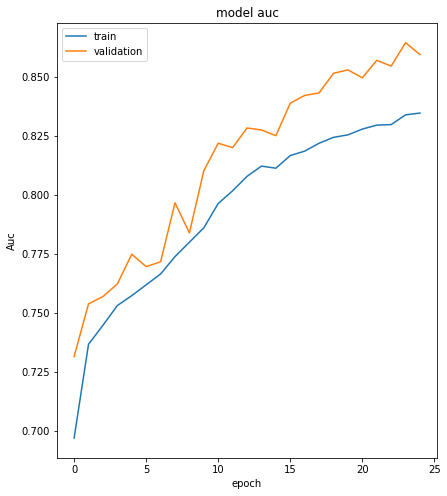

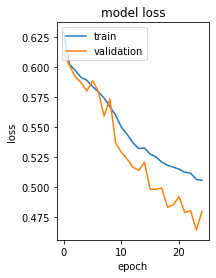

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Colab_Notebooks/DM/Project_6/sample_submission_7.csv')

Private score: 0.81744

### Trial_8
Layer: GNN

Using message_calculation_class = 'RGCN'

When I change dropout value from 0.2 to 0.3 the accuracy decreased so i will change it again into 0.2 and increase the epochs and change number of hidden dimension. I think the accuracy will be increased.

In [ ]:
data = keras.Input(batch_shape=(None,))           #Input to layer

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Links
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params['message_calculation_class'] = 'RGCN'
params['layer_input_dropout_rate'] = 0.2          #Dropout to prevent overfitting
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(                               #segment_mean: computes the mean along segments of a tensor.
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []        

In [ ]:
# compile model with loss values for each task, AUC matrix 
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Fit the model
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(                #GNN model
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=25, repeat=True
    ),
    validation_steps=num_batchs_validation, callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5)
    ],
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_values:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense

2530/2530 [==============================] - 61s 22ms/step - loss: 0.6333 - auc: 0.6918 - val_loss: 0.6152 - val_auc: 0.7247
Epoch 2/50
2530/2530 [==============================] - 41s 16ms/step - loss: 0.6054 - auc: 0.7337 - val_loss: 0.6104 - val_auc: 0.7533
Epoch 3/50
2530/2530 [==============================] - 55s 22ms/step - loss: 0.5933 - auc: 0.7496 - val_loss: 0.5837 - val_auc: 0.7653
Epoch 4/50
2530/2530 [==============================] - 41s 16ms/step - loss: 0.5779 - auc: 0.7667 - val_loss: 0.5852 - val_auc: 0.7814
Epoch 5/50
2530/2530 [==============================] - 46s 18ms/step - loss: 0.5686 - auc: 0.7787 - val_loss: 0.5506 - val_auc: 0.8002
Epoch 6/50
2530/2530 [==============================] - 42s 16ms/step - loss: 0.5564 - auc: 0.7890 - val_loss: 0.5372 - val_auc: 0.8101
Epoch 7/50
2530/2530 [==============================] - 41s 16ms/step - loss: 0.5470 - auc: 0.7981 - val_loss: 0.5374 - val_auc: 0.8102
Epoch 8/50
2530/2530 [==============================] - 40s

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)

y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.9394912 , 0.7224652 , 0.00334209, ..., 0.10558465, 0.30862218,
       0.3571731 ], dtype=float32)

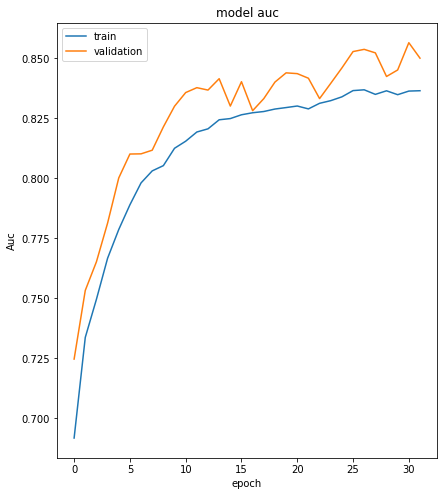

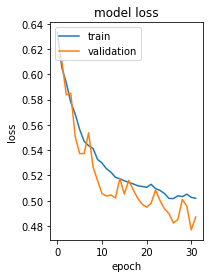

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Colab_Notebooks/DM/Project_6/sample_submission_8.csv')

Private score: 0.80778

### Trial_9
Layer: GNN

Using message_calculation_class = 'RGAT'

I will try to use different message_calculation_class with layer_input_dropout_rate to improve the accuracy and reduce the overfitting.

As RGAT uses gated skip connections to improve long-range modeling between nodes and uses a more scalable vector-based approach for parameterizing relations to avoid vanishing gradients, over-parameterization, and oversmoothing.  so I think it will be improve the accuracy.

In [ ]:
data = keras.Input(batch_shape=(None,))           #Input to layer

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Links
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params['message_calculation_class'] = 'RGAT'
params['layer_input_dropout_rate'] = 0.2          #Dropout to prevent overfitting
params['num_heads'] = 2
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(                               #segment_mean: computes the mean along segments of a tensor.
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []        

In [ ]:
# compile model with loss values for each task, AUC matrix 
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Fit the model
batch_size = 20
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(                #GNN model
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=25,
    validation_data=gen_batch(
        validation_set, batch_size=25, repeat=True
    ),
    validation_steps=num_batchs_validation, callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5)
    ],
)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amo

2024/2024 [==============================] - 55s 24ms/step - loss: 0.6281 - auc: 0.7019 - val_loss: 0.6098 - val_auc: 0.7418
Epoch 2/25
2024/2024 [==============================] - 46s 23ms/step - loss: 0.5959 - auc: 0.7493 - val_loss: 0.5870 - val_auc: 0.7583
Epoch 3/25
2024/2024 [==============================] - 45s 22ms/step - loss: 0.5846 - auc: 0.7621 - val_loss: 0.5786 - val_auc: 0.7717
Epoch 4/25
2024/2024 [==============================] - 45s 22ms/step - loss: 0.5710 - auc: 0.7765 - val_loss: 0.5652 - val_auc: 0.7864
Epoch 5/25
2024/2024 [==============================] - 46s 23ms/step - loss: 0.5560 - auc: 0.7911 - val_loss: 0.5410 - val_auc: 0.8076
Epoch 6/25
2024/2024 [==============================] - 45s 22ms/step - loss: 0.5428 - auc: 0.8031 - val_loss: 0.5476 - val_auc: 0.8058
Epoch 7/25
2024/2024 [==============================] - 47s 23ms/step - loss: 0.5359 - auc: 0.8094 - val_loss: 0.5189 - val_auc: 0.8243
Epoch 8/25
2024/2024 [==============================] - 46s

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)

y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.88240504, 0.6783966 , 0.02312112, ..., 0.01701561, 0.38056463,
       0.20462102], dtype=float32)

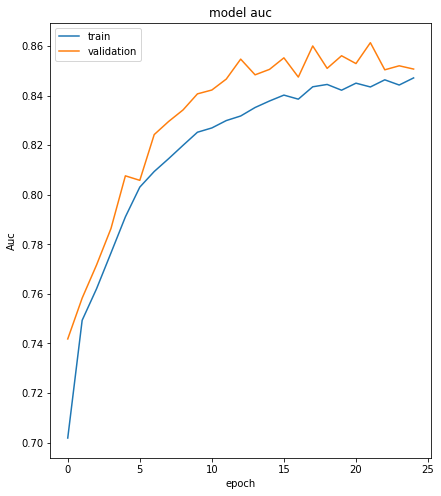

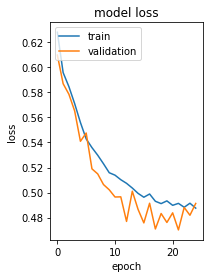

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Colab_Notebooks/DM/Project_6/sample_submission_9.csv')

Private score: 0.80779

### Trial_10
Layer: GNN

Using message_calculation_class = 'RGAT'

I will try to use different message_calculation_class with layer_input_dropout_rate and global_exchange_mode to improve the accuracy.

In [ ]:
data = keras.Input(batch_shape=(None,))           #Input to layer

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) #Links
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params['message_calculation_class'] = 'RGAT'
params['layer_input_dropout_rate'] = 0.2          #Dropout to prevent overfitting
params['num_heads'] = 2
params['global_exchange_mode'] = 'mean'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(                               #segment_mean: computes the mean along segments of a tensor.
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                  

In [ ]:
# compile model with loss values for each task, AUC matrix 
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Fit the model
batch_size = 20
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(                #GNN model
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=25, repeat=True
    ),
    validation_steps=num_batchs_validation, callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5)
    ],
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amo

2024/2024 [==============================] - 54s 25ms/step - loss: 0.6351 - auc: 0.6904 - val_loss: 0.6098 - val_auc: 0.7331
Epoch 2/50
2024/2024 [==============================] - 51s 25ms/step - loss: 0.6066 - auc: 0.7313 - val_loss: 0.6177 - val_auc: 0.7367
Epoch 3/50
2024/2024 [==============================] - 50s 25ms/step - loss: 0.5968 - auc: 0.7468 - val_loss: 0.5920 - val_auc: 0.7568
Epoch 4/50
2024/2024 [==============================] - 50s 24ms/step - loss: 0.5889 - auc: 0.7561 - val_loss: 0.5762 - val_auc: 0.7733
Epoch 5/50
2024/2024 [==============================] - 49s 24ms/step - loss: 0.5761 - auc: 0.7688 - val_loss: 0.5670 - val_auc: 0.7824
Epoch 6/50
2024/2024 [==============================] - 48s 24ms/step - loss: 0.5692 - auc: 0.7760 - val_loss: 0.5550 - val_auc: 0.7966
Epoch 7/50
2024/2024 [==============================] - 49s 24ms/step - loss: 0.5644 - auc: 0.7823 - val_loss: 0.5540 - val_auc: 0.7969
Epoch 8/50
2024/2024 [==============================] - 49s

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)

y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.9182154 , 0.2949111 , 0.01645336, ..., 0.0430204 , 0.8077595 ,
       0.4453944 ], dtype=float32)

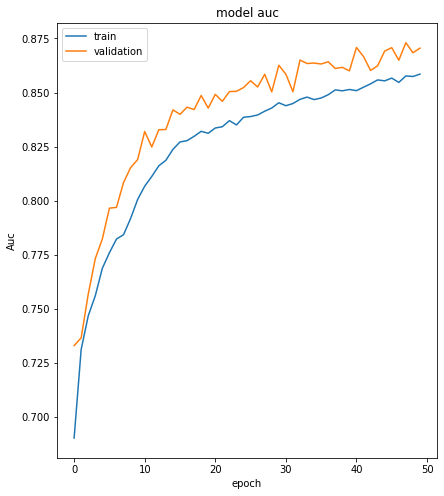

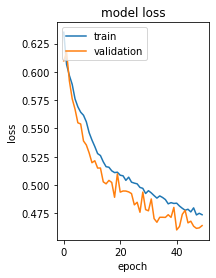

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Colab_Notebooks/DM/Project_6/sample_submission_10.csv')

Private score: 0.82707

#Questions

**Q1\ Based on the provided template, describe the format of the input file (sdf file).**

The input file is (SDF) structure data file. It store information on a molecule's chemical composition. and also It is about the positions of individual atoms in a chemical molecule as well as the connections between them. The expression "$$$" differentiates between different molecules.

Each sample/molecule begins with a header that describes the compound's name. Othe sections include details on the amount of atoms, the version number, and connections, among other things. The elements of the molecule are described in the atom block. The bond blocks describes the compound's bonding structure. Both of these blocks are used in this assignment to obtain information about the compound and save it as edges and nodes.

Data consists of many characters called nodes like N C S O. 
It consists of links between nodes like 1 5 which means the link between node number 1 with node number 5. The end of each sample has a label value.




**What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?**

Data consists of many characters called **nodes** like N C S O, and The shape for each batch is [batch_size*max_len_nodes].

It consists of links between nodes like 1 5 which means the link between node number 1 with node number 5 called **edges**. and The shape of edge is [sum_of_all_edges,2].

The end of each sample has a **label** value[1, -1].

**For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?**

**gnn_out**: 
[batch size node dimension, hidden layers] is the shape of the gnn_out, where batch size node dimension is the dimension of the tokenized vector for the entire batch is the dimension of the input data node vector. For each hidden layer, it represents the model's aggregation output.

**avg**:
The segmented mean of the gnn_out is calculated using the segmented ids. The output of gnn out is [tokenized vector dimension, hidden layers] for each sample in the batch size. The average tensor's final output is of the shape [batch size, hidden layer]. It's a method of gathering information for each sample and presenting it as mean data.

**What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?**

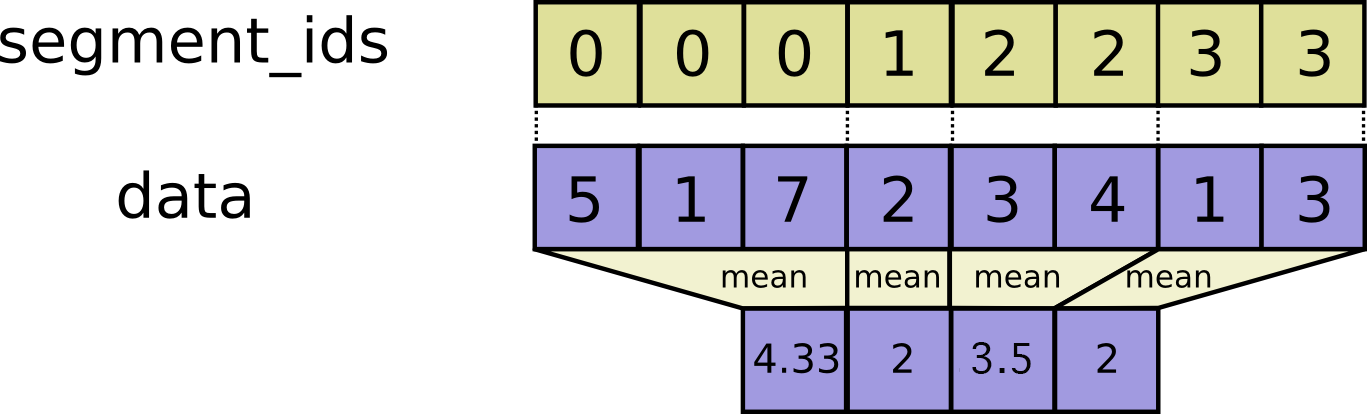

reference: https://www.tensorflow.org/api_docs/python/tf/math/segment_mean


segment_mean: 
Computes mean value base on each segmant 

reduce_mean:
Computes the mean of elements through dimensions of a tensor.

For example:

ar = [[1, 2],
      [3, 4]]

 reduce_mean(ar, axis = 0) = [(3+1)/2.0 = 4, (2+4)/2.0 = 3]

 reduce_mean(ar, axis = 1) = [(2+1)/2.0 = 1.5, (3+4)/2.0 = 3.5]


**What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?**

The motivation used multiple graph convolution network. In the template I used default message passing method is rgcn (Graph convolution layers) and it has 4 layer . We can stack more layers to get a deeper GCN. A deep GCN (more than 7 layers)

#References

* https://www.cs.toronto.edu/~yujiali/files/talks/iclr16_ggnn_talk.pdf

* https://towardsdatascience.com/graph-neural-networks-for-multi-relational-data-27968a2ed143

* https://openreview.net/forum?id=v-9E8egy_i

* https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

* https://arxiv.org/pdf/1511.05493.pdf